In [1]:
import os
os.chdir('/content/drive/MyDrive/Projects')


In [2]:
import os
os.chdir('/content/drive/MyDrive/Projects/data-science-projects')

In [3]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 2.0.1+cu118


3 classes:
['circle', 'square', 'triangle']


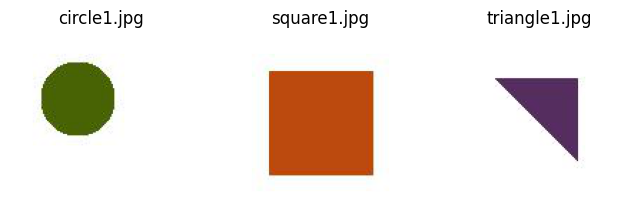

In [4]:
 #The images are in the data/shapes folder
data_path = 'datasets/shapes/'

# Get the class names
classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
fig = plt.figure(figsize=(8, 12))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
plt.show()

## Load data

In [5]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
  transformation = transforms.Compose([
      # Transform data to tensors
      transforms.ToTensor(),
      # Normalize the pixel values in (R,G,B channels)
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])
  ])

  # Load all of the images, transforming them
  full_dataset = torchvision.datasets.ImageFolder(
      root = data_path,
      transform = transformation
  )

  train_size = int(0.7 * len(full_dataset))
  test_size = len(full_dataset) - train_size
  train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size,test_size])

  # Define a loader for training data we can iterate through in 50-image batches
  # define a loader for the training data we can iterate through in 50-image batches
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=50,
      num_workers=0,
      shuffle=False
  )
    
  # define a loader for the testing data we can iterate through in 50-image batches
  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=50,
      num_workers=0,
      shuffle=False
  )
        
  return train_loader, test_loader


# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)
print('Data loaders ready')

Data loaders ready


## Define the CNN

In [6]:
class Net(nn.Module):
  # Constructor
  def __init__(self, num_classes=3):
    super(Net, self).__init__()

    # Our images are RGB, so input channels = 3. We'll apply 12 filters in the first convolutional layer
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)

    # We'll apply max pooling with a kernel size of 2
    self.pool = nn.MaxPool2d(kernel_size=2)

    # A second convolutional layer takes 12 input channels, and generates 12 outputs
    self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        
    # A third convolutional layer takes 12 inputs and generates 24 outputs
    self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
    # A drop layer deletes 20% of the features to help prevent overfitting
    self.drop = nn.Dropout2d(p=0.2)

    # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
    # So our feature tensors are now 32 x 32, and we've generated 24 of them
    # We need to flatten these and feed them to a fully-connected layer
    # to map them to  the probability for each class
    self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

  
  def forward(self, x):
      # Use a relu activation function after layer 1 (convolution 1 and pool)
      x = F.relu(self.pool(self.conv1(x)))
      
      # Use a relu activation function after layer 2 (convolution 2 and pool)
      x = F.relu(self.pool(self.conv2(x)))
        
      # Select some features to drop after the 3rd convolution to prevent overfitting
      x = F.relu(self.drop(self.conv3(x)))
        
      # Only drop the features if this is a training pass
      x = F.dropout(x, training=self.training)
        
      # Flatten
      x = x.view(-1, 32 * 32 * 24)
      # Feed to fully-connected layer to predict class
      x = self.fc(x)
      # Return log_softmax tensor 
      return F.log_softmax(x, dim=1)
    
print("CNN model class defined!")

CNN model class defined!


## Train the model

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    


## Peform training and prediction

In [8]:
# Now use the train and test functions to train and test the model    

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 5 epochs (in a real scenario, you'd likely use many more)
epochs = 5
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
Training set [0/840 (0%)] Loss: 1.101213
Training set [500/840 (59%)] Loss: 0.748261
Training set: Average loss: 0.858587
Validation set: Average loss: 0.488685, Accuracy: 285/360 (79%)

Epoch: 2
Training set [0/840 (0%)] Loss: 0.479290
Training set [500/840 (59%)] Loss: 0.297503
Training set: Average loss: 0.394149
Validation set: Average loss: 0.284816, Accuracy: 305/360 (85%)

Epoch: 3
Training set [0/840 (0%)] Loss: 0.286584
Training set [500/840 (59%)] Loss: 0.175572
Training set: Average loss: 0.234338
Validation set: Average loss: 0.190164, Accuracy: 339/360 (94%)

Epoch: 4
Training set [0/840 (0%)] Loss: 0.195589
Training set [500/840 (59%)] Loss: 0.111189
Training set: Average loss: 0.126826
Validation set: Average loss: 0.086959, Accuracy: 356/360 (99%)

Epoch: 5
Training set [0/840 (0%)] Loss: 0.096336
Training set [500/840 (59%)] Loss: 0.063885
Training set: Average loss: 0.062504
Validation set: Average loss: 0.036793, Accuracy: 358/360 (99%)



## Evaluate model performance

Getting predictions from test set...


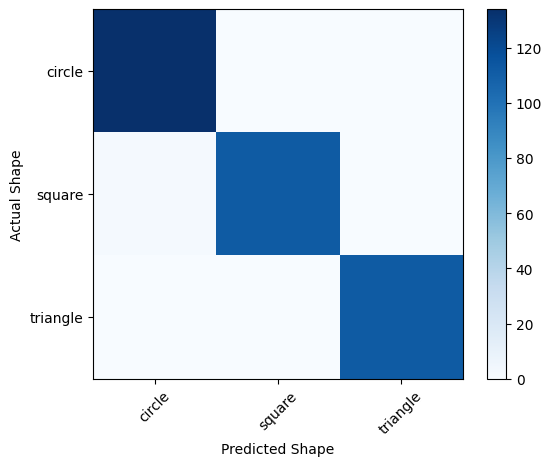

In [9]:
from sklearn.metrics import confusion_matrix

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## Save the trained model

In [10]:
# Save the model weights
model_file = 'models/shape_classifier.pt'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as models/shape_classifier.pt


## Use trained model

circle


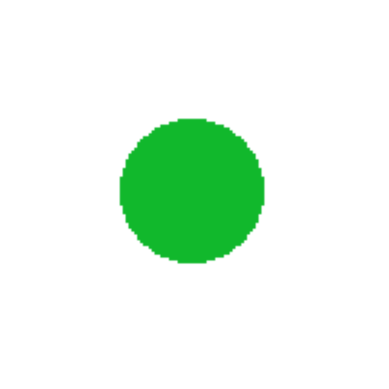

In [11]:
import matplotlib.pyplot as plt
import os
from random import randint
%matplotlib inline


# Function to predict the class of an image
def predict_image(classifier, image):
    import numpy
    
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index


# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)

# Create a random test image
classnames = os.listdir(os.path.join('datasets', 'shapes'))
classnames.sort()
shape = classnames[randint(0, len(classnames)-1)]
img = create_image ((128,128), shape)

# Display the image
plt.axis('off')
plt.imshow(img)

# Create a new model class and load the saved weights
model = Net()
model.load_state_dict(torch.load(model_file))

# Call the predction function
index = predict_image(model, img)
print(classes[index])